In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from lets_plot import *
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import numpy as np
from joblib import Parallel, delayed
from toolz import partial

LetsPlot.setup_html()

# 1. ATE FOR A CONTINOUS TREATMENT

Using the same dataset with continuous treatment from the cap5_CI notebook, it is going to be estimated the CATE.

In [52]:
dataset_risk=pd.read_csv("risk_data.csv")

For the confidence intervals of the predictions it will be used the same boostrap function:

In [75]:
def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    
    np.random.seed(seed)
    
    # list compression  with ATEs
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(data.sample(frac=1, replace=True))# setting the func to be executed parallely ti data.sample as first param
        for _ in range(rounds) 
    )
    
    mean_stat = np.mean(stats)
    
    # Calculate the standard error of the bootstrap statistics, ddof=1 because dataset is a sample, not all the population
    se_stat = np.std(stats, ddof=1)
    
    # Calculate the relative standard error
    se_relative = (se_stat / mean_stat)*100
    
    return np.percentile(stats, pcts), se_relative

## 1.1.Getting the CATE

It is going to be used a logistic regression model that has into account the interaction between treatment and covaribales_x to predict outcome Y.

In [76]:
def cate_mean(dataset_risk, outcome, covariates_x, treatment):
    logit_cate = smf.logit(f"{outcome} ~ {treatment}*{'+'.join(covariates_x)}", data=dataset_risk).fit()
    
    predictions = logit_cate.predict(dataset_risk[covariates_x+[treatment]])
    
    return predictions.mean()

In [78]:
outcome = 'default'
covariates_x = ['credit_score1', 'credit_score2', 'wage']
treatment = 'credit_limit'


partial_cate_mean = partial(cate_mean, outcome=outcome, covariates_x=covariates_x, treatment=treatment)


print("CATE MEAN:", partial_cate_mean(dataset_risk))


confidence_interval, se_relative = bootstrap(dataset_risk, partial_cate_mean)

print(f"95% CI: {confidence_interval}")
print(f"SE RELATIVE: {np.round(se_relative,2)}%")

Optimization terminated successfully.
         Current function value: 0.407618
         Iterations 7
CATE MEAN: 0.1508
95% CI: [0.1475775 0.154261 ]
SE RELATIVE: 1.14%


# 2.PERFECT CONDITIONS FOR MAX TREATMENT EFFECT

## 1.DATA EXPLORATION

In [5]:
dataset=pd.read_csv("discount_data.csv")

In [11]:
dataset.head()

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


**It is going to be substituted the variable day for year as it already exist a variable for month, weekdat but not for year and day contains the year of the unit.**

In [15]:
dataset['day'] = pd.to_datetime(dataset['day'])
dataset_transformed=dataset.assign(year=dataset['day'].dt.year).drop(columns=['day'])

In [16]:
dataset_transformed.describe()

,rest_id,month,weekday,competitors_price,discounts,sales,year
count,7679.00000,7679.000000,7679.000000,7679.000000,7679.00000,7679.000000,7679.000000
mean,3.00000,6.516864,3.000912,5.826608,10.28324,375.941334,2017.000912
std,2.00013,3.451664,2.001725,1.786338,9.70930,331.953960,0.818594
min,0.00000,1.000000,0.000000,1.350000,0.00000,16.000000,2016.000000
25%,1.00000,4.000000,1.000000,4.480000,0.00000,71.000000,2016.000000
50%,3.00000,7.000000,3.000000,5.700000,10.00000,283.000000,2017.000000
75%,5.00000,10.000000,5.000000,7.120000,15.00000,551.000000,2018.000000
max,6.00000,12.000000,6.000000,9.970000,45.00000,2265.000000,2019.000000


In [17]:
num_unique_values = dataset_transformed.nunique()
# Iterate over the columns and print the number of unique values
for column, num_values in num_unique_values.items():
    print(f"{column}: {num_values}")
    
print(dataset_transformed.shape)

rest_id: 7
month: 12
weekday: 7
weekend: 2
is_holiday: 2
is_dec: 2
is_nov: 2
competitors_price: 799
discounts: 10
sales: 1873
year: 4
(7679, 11)


To do variable selection, variables with high correlation with the outcome sales are explored.

The next variables have the most correlation with sales: rest_id, month, weekday, is_dec, is_nov, competitors_price and the treatment discounts.

As there is significant correlation between variables as mont with is_dec or is_nov and rest_id with competitors_price, **to avoid problems of multicollinearity they will be selected: competitors_price, month, weekday and the treatment discounts.**

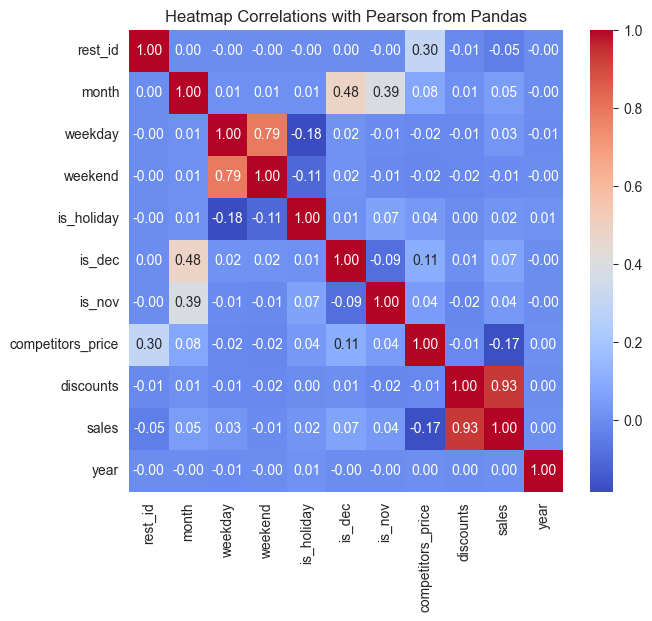

In [18]:
correlation_matrix_pandas = dataset_transformed.corr()
plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix_pandas, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Correlations with Pearson from Pandas')
plt.show()

Using boxplot is possible to see a **little peak of sales on fridays. Although, it doesn't look significant.**

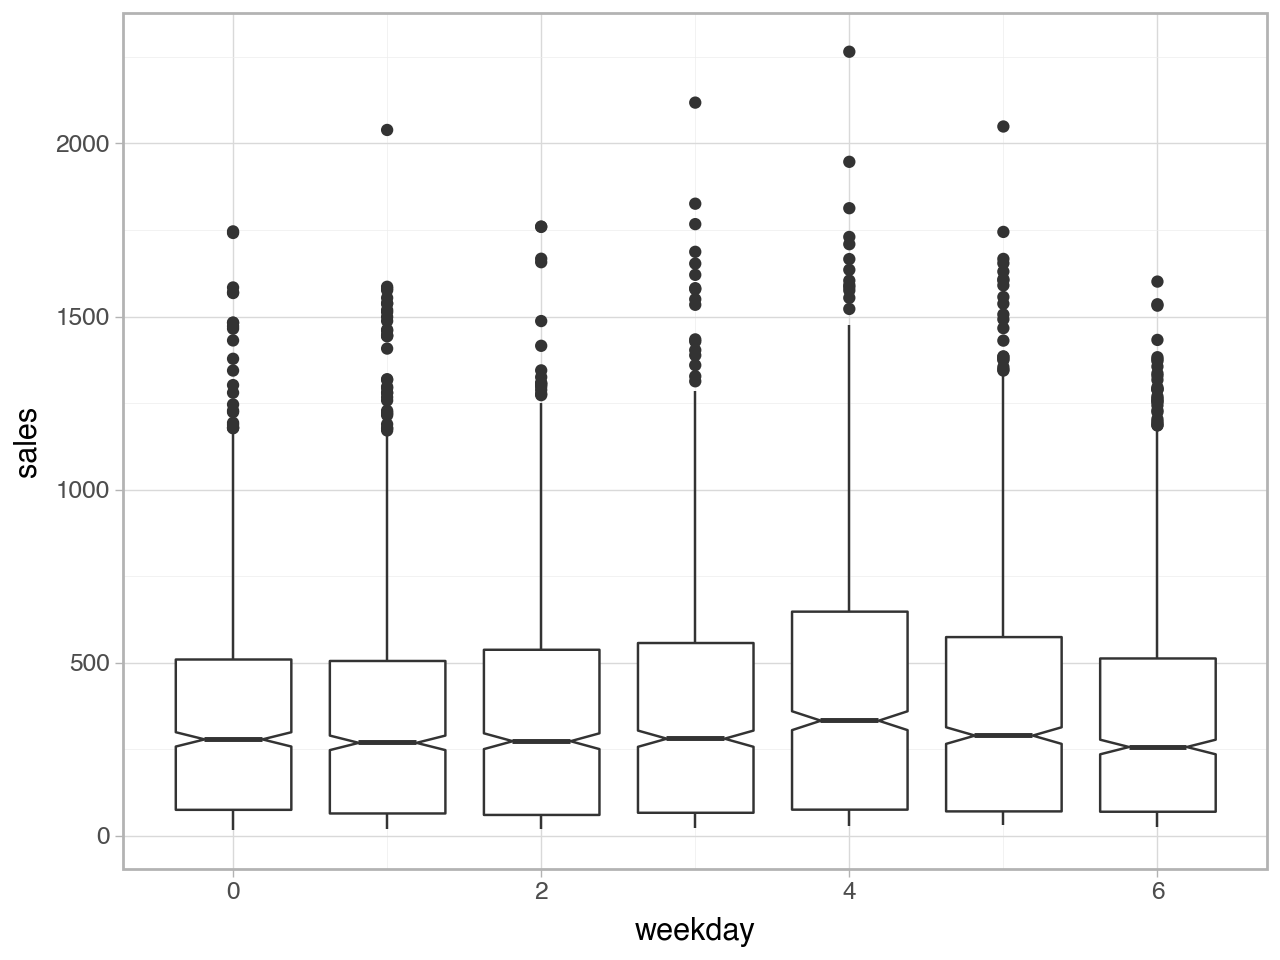

In [33]:
plot = (
    p9.ggplot(dataset_transformed, p9.aes(x='weekday', y='sales', group='weekday'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("")
)
plot.show()

**On summer, the sales decrease** as it is possible to observe on the next box plot.

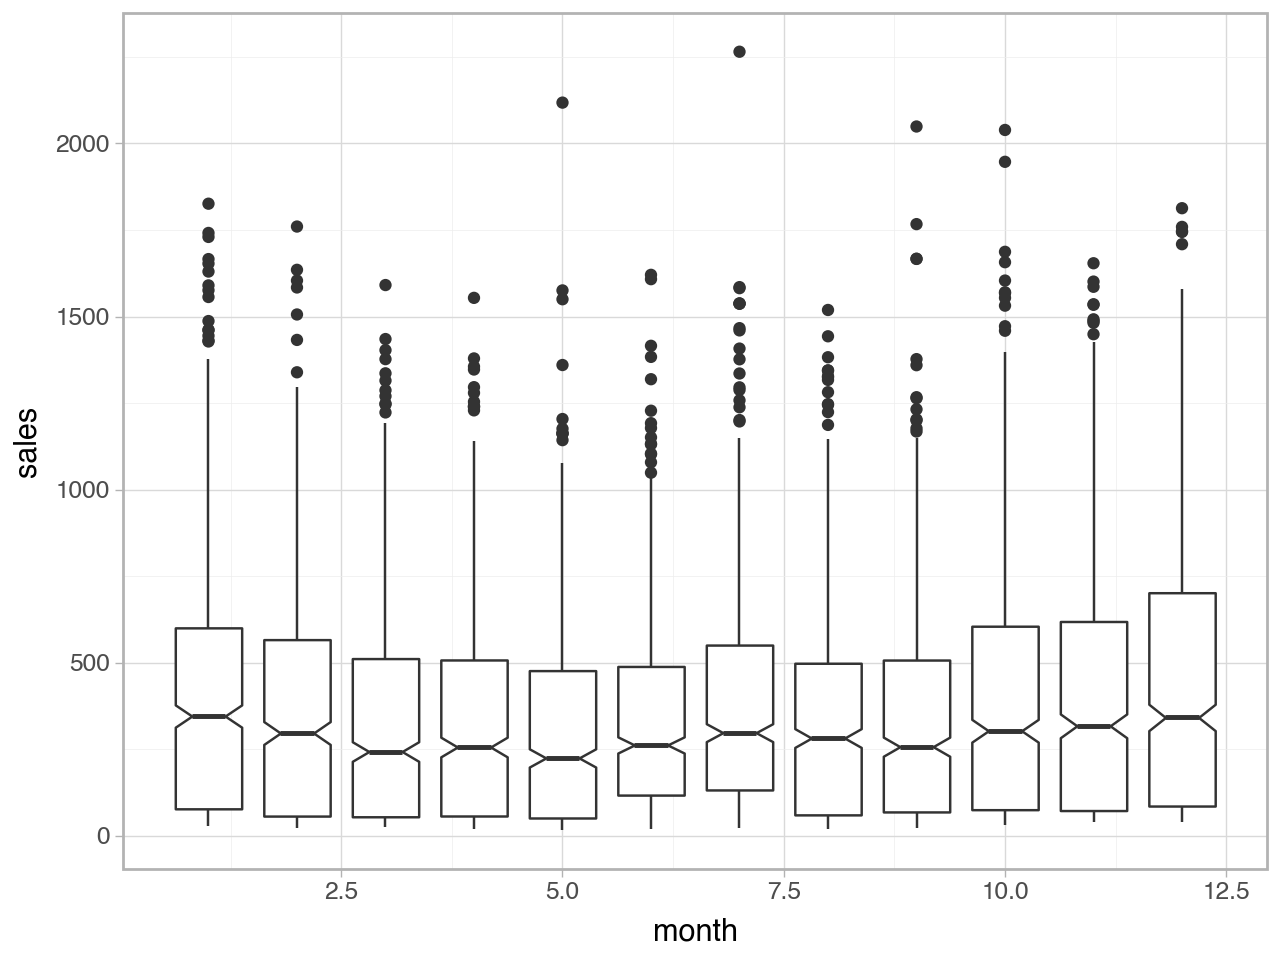

In [32]:
plot = (
    p9.ggplot(dataset_transformed, p9.aes(x='month', y='sales', group='month'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("")
)
plot.show()

As the price of the **competitors price grow, sales decrease.**

In [40]:
(ggplot(dataset_transformed, aes(x='competitors_price', y='sales')) +
 geom_point())

## 2.CATE REGRESSION

To obtain the CATE to evaluate the response of each unit to the treatment, it will be used a linear regression with the treatment, covariables x and the interaction between covariables x and treatment as independent variables.

In [47]:
X = ['C(month)', 'competitors_price','C(weekday)']

Spltting the dataset to evaluate the lineal regression CATE predictions: